# Image Generation using Auto Encoders

Autoencoders are a type of neural networks where the input is also the output. They come under unsupervised learning and there are no labels involved. An auto encoder consists of two parts: encoder and decoder. The follow the same principal of dimensionality reduction as in Linear Algebra but with a neural network. The idea here is that you take a higher dimensional input, project it into a lower dimensional space and then project it back into the input space. Fig 1 shows the typical architecture of autoencoders.

Encoder receives the input and encodes it into a lower dimenstion. This encoding is simply called code. The code represents the summary of the input. The decoder takes this code and reconstructs the input from it.

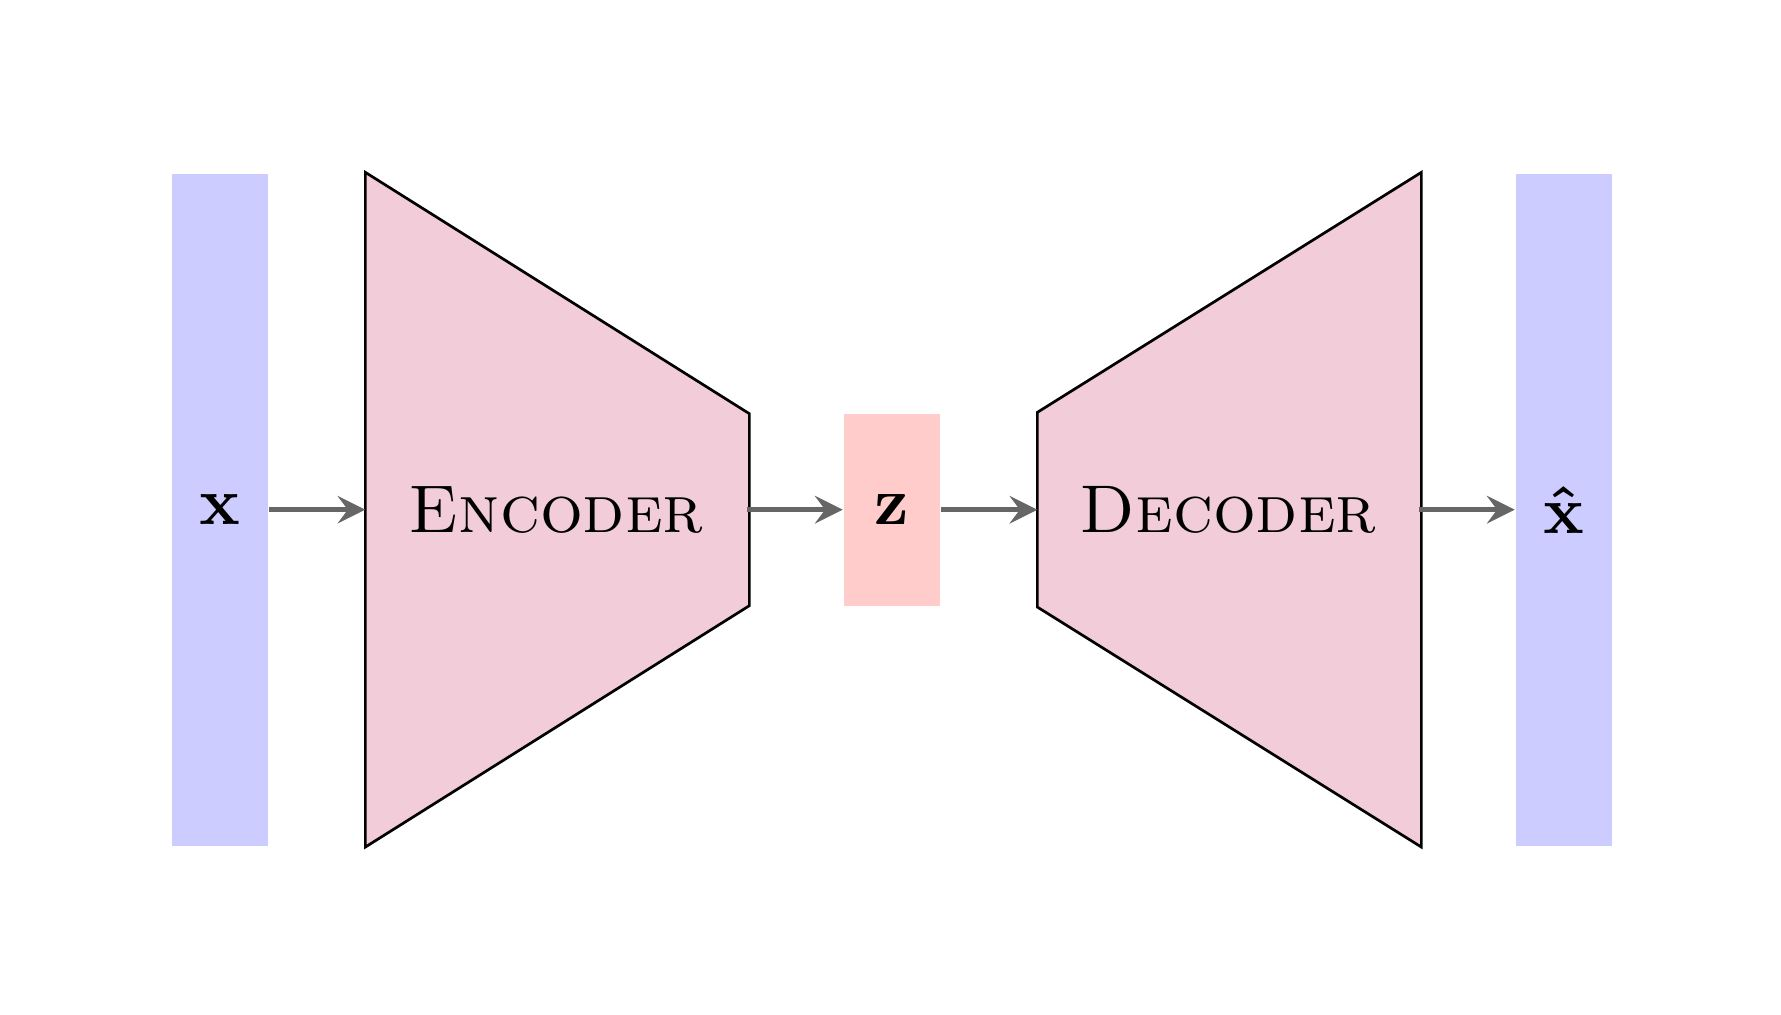
<p align = "center">
Fig.1 - Autoencoder Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

We will try to visualize the generative power of autoencoders in this tutorial by generating new samples based on input images. Some other use cases of autoencoders include the following.
 - Image Denoising (the input is noisy image and output is denoised image)
 - Image completion (the input is an image with a patch missing and the output is completed image)
 - Data encoding and dimenensionality reduction.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
Z = 32

In [ ]:
# We will be using the mnist digit data.
mnist_dataset = datasets.MNIST(root="minist_data/", download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 372675791.00it/s]

Extracting minist_data/MNIST/raw/train-images-idx3-ubyte.gz to minist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 121866895.20it/s]


Extracting minist_data/MNIST/raw/train-labels-idx1-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 126225431.59it/s]

Extracting minist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to minist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2015928.97it/s]

Extracting minist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to minist_data/MNIST/raw



In [ ]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

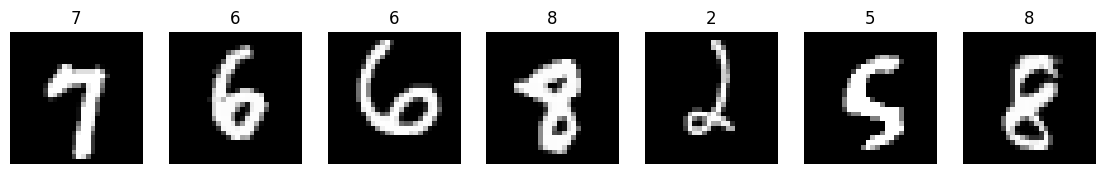

In [ ]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We will build the autoencoder model now. It is common practice to build the encoder and decocder as inverses of each other but that's not really necessary as long as the input and output space is same.

The represention power of the encoder depends on the encoder size and the encoding dimension. The larger the encoder network and the value of z (encoding dimension) the better the representation but it usually comes at the cost of overfitting so we have balnce the two.

There usually is no activation on the encoding but here since our goal is to sample the encodings and generate new samples it is better to limit the space of encodings. Therefore, we will be applying tanh activation at the encoding layer to limit the encoding space.

In [ ]:
class VAE(nn.Module):
  def __init__(self, dz):
    super().__init__()
    self.en1 = nn.Linear(784, 500)
    self.ebn1 = nn.BatchNorm1d(500)
    self.en2 = nn.Linear(500, 100)
    self.ebn2 = nn.BatchNorm1d(100)
    self.en3 = nn.Linear(100, dz)

    self.lmu = nn.Linear(dz, dz)
    self.llogvar = nn.Linear(dz, dz)

    self.de1 = nn.Linear(dz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.de2 = nn.Linear(100, 500)
    self.dbn2 = nn.BatchNorm1d(500)
    self.de3 = nn.Linear(500, 784)
    self.mu = 0
    self.logvar = 0

  def encoder_head(self, x):
    x = x.view(-1,784)
    x = self.en1(x)
    x = torch.sigmoid(x)
    x = self.ebn1(x)

    x = self.en2(x)
    x = torch.sigmoid(x)
    x = self.ebn2(x)

    x = self.en3(x)
    x = torch.sigmoid(x)
    return x

  def get_params(self, x):
    mu = self.lmu(x)
    logvar = self.llogvar(x)
    return mu, logvar

  def encoder(self, x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = self.reparam(mu, logvar)
    return z, mu, logvar

  def reparam(self, mu, logvar):
    sig = torch.exp(0.5*logvar)
    eps = torch.randn_like(sig)
    z = mu + sig*eps
    return z


  def decoder(self, z):
    z = self.de1(z)
    z = torch.sigmoid(z)
    z = self.dbn1(z)

    z = self.de2(z)
    z = torch.sigmoid(z)
    z = self.dbn2(z)

    z = self.de3(z)
    z = torch.sigmoid(z)
    return z

  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    xhat = self.decoder(z)
    xhat = xhat.view(-1, 1, 28,28)
    return xhat, mu, logvar



In [ ]:
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# exp -(z- mu)/ sig**2
# mu =---> (batch_size, dz)

In [ ]:
def get_loss(X, Xhat, mu, logvar):
  beta = 0.0018
  sig = torch.exp(0.5*logvar)
  recon_loss = F.mse_loss(X,Xhat)
  KL_loss = torch.mean(-0.5*(1+torch.sum(logvar - sig**2 - mu**2, dim =1)), dim =0)
  loss = recon_loss+ beta*KL_loss
  return loss

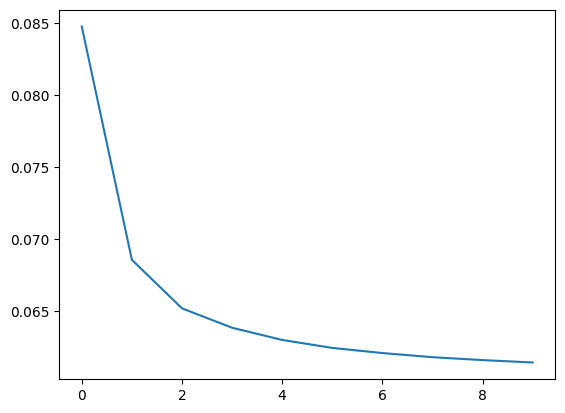

In [ ]:
device = torch.device("cuda:0")
dz = 20
vae = VAE(dz).to(device)
opt = optim.Adam(vae.parameters(), lr = 1e-3)
num_epochs = 10

ls = []
for i in range(num_epochs):
  total_loss = 0
  for j,batch in enumerate(train_dataloader):
    X = batch[0].to(device)
    Xhat, mu, logvar = vae(X)
    loss = get_loss(Xhat, X, mu, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_dataloader))

plt.plot(ls)





Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

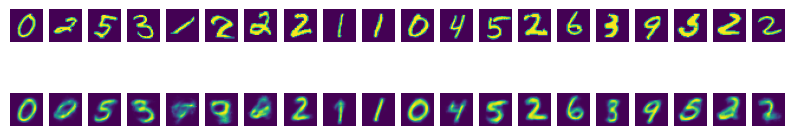

In [ ]:
plt.figure(figsize=(10,2))
for i in range(20):
  plt.subplot(2, 20, i+1)
  plt.imshow(X.detach().cpu()[i,0,:,:])
  plt.axis("off")
  plt.subplot(2, 20, i+21)
  plt.imshow(Xhat.detach().cpu()[i,0,:,:])
  plt.axis("off")


In [ ]:
num_samples = 64
z = torch.randn(num_samples, dz).to(device)
Xhat = vae.decoder(z).view(-1,1, 28,28)


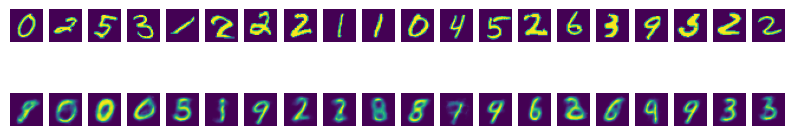

In [ ]:


plt.figure(figsize=(10,2))
for i in range(20):
  plt.subplot(2, 20, i+1)
  plt.imshow(X.detach().cpu()[i,0,:,:])
  plt.axis("off")
  plt.subplot(2, 20, i+21)
  plt.imshow(Xhat.detach().cpu()[i,0,:,:])
  plt.axis("off")

### Generation through Auto Encoders

In [ ]:
Xhat.shape

torch.Size([64, 784])

### Discussion

As we can see, we achieved near perfect image reconstruction for the data with a very small value of Z(=32). One of the reason is obviously because the input data itself of low dimenstion but the other is that autoencoders are fairly good at encoding the data.

But in the case of generation, we did not get good results. This goes to show us that auto encoders have very low generative abilities because they tend to overfit and just learn the function that maps the input to output.

In [ ]:
loss

tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)